# Parallelisation d'un algorithme de boosting

Jacques Song et Tristan Loisel, rendu le 03/02/2020 

Eléments logiciels pour traitement de données massives

Dans ce notebook, nous présentons un algorithme de boosting, codé en `python`, que nous parallelisons à l'aide du package `ray`.

## Import des packages nécessaires

In [1]:
import ray
import time
import numpy as np
import sklearn as sk
from sklearn import tree
from sklearn.linear_model import RidgeClassifier
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

## Construction des sets d'entraînement et de test

Nous avons choisi ici de travailler avec les données "mnist_784", qui contiennent des chiffres manuscrits.

In [2]:
X, y = fetch_openml(name="mnist_784", return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=0)

3


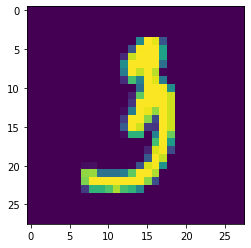

In [3]:
plt.imshow(np.reshape(X_train[0], (28, 28)))
print(y_train[0])

## L'algorithme:

L'algorithme que nous implémentons est le suivant, il a été présenté par Aleksandar LAZAREVIC et Zoran OBRADOVIC dans *Boosting Algorithms for Parallel and Distributed Learning, Distributed and Parallel Databases, 11, 203–229, 2002*.


 Entrée: un set de données labellisées $S = \{(X_i,Y_i)\}_{i \in \{1,...,n\}}$, avec pour chaque $i$, $y_i \in \{0,...,9\}$

Initialisation: création 

&nbsp;&nbsp;&nbsp;-d'un ensemble $B=\{(i,y), i \in \{1,...,n\}, y_i \neq y\}$

&nbsp;&nbsp;&nbsp;-d'une densité de probabilité sur S, $\mu_1$, telle que $\mu_1(i)=\frac{1}{n}$ pour chaque $i \in \{1,...,n\}$.

Pour chaque $t \in \{1,...,T\}$:

&nbsp;&nbsp;&nbsp;Pour chaque processeur $j \{1,...,J\}$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Tirer un échantillon à partir de la densité $\mu_t$
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Entraîner un prédicteur $P_{t,j}$ en utilisant le processeur $j$
        
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-Calculer sa prédiction $h_{t,j}$ de ce prédicteur
 
Créer le prédicteur $h_t$ tel que: $h_t(i) = max\{h_{t,j}(i), j \in \{1,...,J\}$

Calculer la perte de $h_t$: $L_t = \frac{1}{2} \sum_{(i,y) \in B} \mu_t (i,y) (1-h_t (x_i, y_i)+h_t (x_i,y))$

Calculer $\mu_{t+1}(i,y) = \frac{\mu_{t}(i,y)}{C_t} \beta_t^{w_{t,i}}$ où $\beta_t = \frac{L_t}{1 - L_t}$, $w_{t,i} =  \frac{1}{2}(1-h_t (x_i, y)+h_t (x_i,y_i))$ et $C_t$ est une constante de normalisation.

Retourner $h = argmax_{y \in \{0,...,9\}} \sum_{t \in \{1,...,T\}} log(\frac{1}{\beta_t})h_t(.,y)$



## Définition de quelques fonctions utiles

In [4]:
@ray.remote(num_return_vals=2)
def resample(probs, sample_size):
    counts = np.random.multinomial(sample_size, probs)
    samples = []
    labels = []
    samples.append(sample(counts, X_train))
    labels.append(sample(counts, y_train))
    return samples, labels

def sample(counts, data):
    sample = []
    for index, count in enumerate(counts):
        for _ in range(count):
            sample.append(data[index])
    return np.array(sample)

@ray.remote
def train_weak_learner(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

@ray.remote
def make_hypothesis(model):
    def fun(X, y):
        return int(model.predict([X])==y)
    return fun

def merge_hypothesis(hypotheses):
    def fun(X, y):
        return max([hypotheses[k](X, y) for k in range(P)])
    return fun

# def final_hypothesis(learners_list, betas_list):
#     def fun(X):
#         return str(np.argmax(
#             [sum([- np.log(betas_list[t]) * 
#                   learners_list[t](X, y)
#                   for t in range(T)]) 
#              for y in classes]))
#     return fun

def make_final_classifier(hypothesis_list, betas_list):
    def fun(X):
        temp_classes_score = []
        for y in classes:
            temp_it_score = []
            for t in range(T):
                temp_it_score.append(betas_list[t] * hypothesis_list[t](X, y))
            temp_classes_score.append(sum(temp_it_score))
        return str(np.argmax(temp_classes_score))
    return fun

def update_weights(D, beta, hypothesis):
    res = np.empty(shape=(N,), dtype=np.float32)
    index = 0
    for X, y in zip(X_train, y_train):
        res[index] = D[index] * np.exp(- beta * hypothesis(X, y))
        index += 1
    res = res / sum(res)
    return res

## Définition des paramètres

In [5]:
N = np.shape(X_train)[0]
T = 100
P = 10

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Implémentation de l'algorithme

In [6]:
ray.init(num_cpus=P)

2020-02-03 18:42:14,038	INFO resource_spec.py:212 -- Starting Ray with 3.86 GiB memory available for workers and up to 1.94 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-03 18:42:14,422	INFO services.py:1093 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.31',
 'redis_address': '192.168.1.31:27413',
 'object_store_address': '/tmp/ray/session_2020-02-03_18-42-14_025352_87319/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-03_18-42-14_025352_87319/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-02-03_18-42-14_025352_87319'}

Initialize boosting weights

In [7]:
D = []
D.append(np.ones(shape=(N,), dtype=np.float32)/N)

In [8]:
B_X = []
B_y = []
for X, y in zip(X_train, y_train):
    for char in classes:
        if char != y:
            B_X.append(X)
            B_y.append(char)

In [9]:
def loss(hypothesis, D):
    epsilon = 0
    for i in range(N):
        neg = hypothesis(X_train[i], y_train[i])
        coef = D[i]
        for j in range(9):
            epsilon += coef * (1 - neg + hypothesis(X_train[i], B_y[9*i + j]))
    return .5 * epsilon

In [10]:
def error_pred_list(hypothesis):
    res = []
    for i in range(N):
        res.append(1 - hypothesis(X_train[i], y_train[i]))
    return np.array(res)[:, np.newaxis]

def weighted_average(D, pred_list):
    return np.dot(D, pred_list)

def ada_loss(hypothesis, D):
    return weighted_average(D, error_pred_list(hypothesis))

Heart of the training

In [11]:
hypothesis_list = []
betas_list = []
for t in tqdm.trange(T):
    data_samples_id = []
    fitted_models_id = []  # list for storing the future fitted models
    hypotheses_id = []  # list for storing the future weak hypotheses
    weak_learners = [tree.DecisionTreeClassifier(max_depth=4) for k in range(P)]  # list of weak learners
    for k in range(P):
        data_samples_id.append(resample.remote(D[-1], sample_size=N))
    data_samples = [ray.get(data_id) for data_id in data_samples_id]
    for k in range(P):
        # parallelize training of weak learner k
        model_id = train_weak_learner.remote(weak_learners[k], data_samples[k][0][0], data_samples[k][1][0])
        # add future fitted model id
        fitted_models_id.append(model_id)
        # add future hypothesis is
        hypotheses_id.append(make_hypothesis.remote(model_id))
        
    fitted_models = ray.get(fitted_models_id)  # get fitted weak learners
    weak_hypotheses_list = ray.get(hypotheses_id)  # get weak hypotheses
    hypothesis = merge_hypothesis(weak_hypotheses_list)  # compute strong hypothesis
    hypothesis_list.append(hypothesis)  # store strong hypothesis
    epsilon = ada_loss(hypothesis, D[-1])  # compute strong hypothesis loss
    if epsilon == 0:
        print("No error")
        epsilon += 0.00001
    betas_list.append(.5 * np.log((1 - epsilon) / epsilon))
    D.append(update_weights(D[-1], betas_list[-1], hypothesis))
    
final_classifier = make_final_classifier(hypothesis_list, betas_list)

100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


In [12]:
res_final = []
for k in tqdm.trange(100):
    res_final.append(final_classifier(X_test[k]))
res_final = np.array(res_final)

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


In [13]:
print(classification_report(y_test[:100], res_final))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       1.00      1.00      1.00        10
           2       0.71      0.83      0.77         6
           3       1.00      0.89      0.94         9
           4       0.89      0.89      0.89        18
           5       0.78      1.00      0.88        14
           6       1.00      0.83      0.91         6
           7       0.85      0.85      0.85        13
           8       0.75      0.60      0.67         5
           9       0.67      0.80      0.73         5

    accuracy                           0.87       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.88      0.87      0.87       100



In [14]:
X_train.shape

(1000, 784)

In [15]:
def parallel_training(P):
    weak_learners = [tree.DecisionTreeClassifier() for k in range(P)]
    fitted_models_id = []
    for k in range(P):
        # parallelize training of weak learner k
        model_id = train_weak_learner.remote(weak_learners[k], X_train, y_train)
        # add future fitted model id
        fitted_models_id.append(model_id)
    fitted_models = ray.get(fitted_models_id)
    return fitted_models

def sequential_training(P):
    weak_learners = [tree.DecisionTreeClassifier(max_depth=10) for k in range(P)]
    fitted_models = []
    for k in range(P):
        fitted_models.append(weak_learners[k].fit(X_train, y_train))
    return fitted_models

In [18]:
ray.init(num_cpus=P)

2020-02-03 18:46:59,358	INFO resource_spec.py:212 -- Starting Ray with 3.86 GiB memory available for workers and up to 1.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-03 18:46:59,615	INFO services.py:1093 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.31',
 'redis_address': '192.168.1.31:40838',
 'object_store_address': '/tmp/ray/session_2020-02-03_18-46-59_344013_87319/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-03_18-46-59_344013_87319/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-02-03_18-46-59_344013_87319'}

In [19]:
parallel_times = []
sequential_times = []

K = 20

for nbr_trees in tqdm.trange(1, K):
    start = time.time()
    parallel_fitted_models = parallel_training(10 * nbr_trees)
    end = time.time()
    parallel_times.append(end - start)

    start = time.time()
    sequential_fitted_models = sequential_training(10 * nbr_trees)
    end = time.time()
    sequential_times.append(end - start)


100%|██████████| 19/19 [03:21<00:00, 10.59s/it]


[]

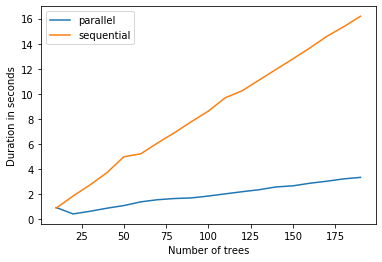

In [20]:
plt.plot(10 * np.arange(1, K), parallel_times, label='parallel')
plt.plot(10 * np.arange(1, K), sequential_times, label='sequential')
plt.xlabel("Number of trees")
plt.ylabel("Duration in seconds")
plt.legend()
plt.plot()

[]

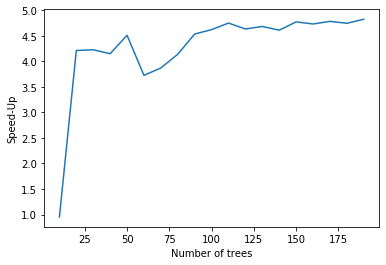

In [21]:
plt.plot(10 * np.arange(1, K), np.array(sequential_times) / np.array(parallel_times))
plt.xlabel("Number of trees")
plt.ylabel("Speed-Up")
plt.plot()